## Implementation of U-Net architecture for Pascal VOC 2012 dataset

U-Net: Convolutional Networks for Biomedical Image Segmentation
Olaf Ronneberger, Philipp Fischer, Thomas Brox
https://arxiv.org/abs/1505.04597

In [2]:
%%capture
!pip install segmentation-models-pytorch

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms.v2.functional as F
import segmentation_models_pytorch as smp
import pickle
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
from torchvision.transforms import v2
from torchinfo import summary
from torchvision.datasets import VOCSegmentation, wrap_dataset_for_transforms_v2
from torchvision.utils import make_grid, draw_segmentation_masks
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from PIL import Image

In [4]:
def get_cat_indices(data, non_cat: float=0.1):
    """get all cat images and a fraction of images without cats from the dataset"""
    cat_index = 8
    to_tensor = v2.ToImage()
    cat_indices = []
    non_cat_indices = []
    for idx, (_, mask) in enumerate(data):
        t_mask = to_tensor(mask).flatten()
        t_mask_unique = t_mask.unique()
        if t_mask_unique.equal(torch.tensor([0, 8, 255])):
            cat_indices.append(idx)
        elif non_cat * len(cat_indices) > len(non_cat_indices) and 8 not in t_mask_unique:
            non_cat_indices.append(idx)
            
            
    return cat_indices + non_cat_indices

def overlay_mask(image, mask):
    return Image.blend(image.convert("RGBA"), mask.convert("RGBA"), alpha=0.5)

def show_random_images(data, num_to_display, with_mask=True):
    for idx in np.random.randint(0, len(data), num_to_display):
        image, mask = data[idx]
        plt.figure()
        plt.axis("off")
        if with_mask:
            plt.imshow(overlay_mask(image, mask))
        else:
            plt.imshow(image)

plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 9))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), )
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def show_output_images(model, dl, palette, num=6, show_target=False):
    tfs = v2.Compose([
        v2.ToImage(),
        v2.Resize((512, 512), antialias=True)
    ])
    with torch.inference_mode():
        images, target_masks = next(iter(dl))
        assert num <= len(images)
        out_masks = model(images[:num].to(device)).argmax(dim=1)
        originals = [F.to_pil_image(image) for image in images[:num]]
        out_masks = [F.to_pil_image(mask) for mask in out_masks.byte()]
        target_masks = [F.to_pil_image(mask) for mask in target_masks]
        
        for mask in out_masks:
            mask.putpalette(palette)
        
        if show_target:
            for mask in target_masks:
                mask.putpalette(palette)
            target_masks = [tfs(overlay_mask(orig, mask)) for orig, mask in zip(originals, target_masks)]

        overlayed = [tfs(overlay_mask(orig, mask)) for orig, mask in zip(originals, out_masks)]
        

        
        if show_target:
            show(make_grid(overlayed + target_masks, nrow=num))
        else:
            show(make_grid(overlayed, nrow=num//2))
  

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 224

# whether to use a small binary cat subset for segmentation
cat = True

# Data exploration

In [ ]:
transforms = v2.Resize((IMAGE_SIZE, IMAGE_SIZE))
data = VOCSegmentation("data", image_set="trainval", download=True, transforms=transforms)

In [ ]:
image, mask = data[0]

Store palette for inference

In [ ]:
palette = mask.getpalette()

In [ ]:
with open('palette', 'wb') as fp:
        pickle.dump(palette, fp)

In [ ]:
if cat:
    cat_subset = torch.utils.data.Subset(data, get_cat_indices(data))
    print(len(cat_subset))

In [ ]:
overlay_mask(image, mask)

In [ ]:
show_random_images(cat_subset if cat else data, 5)

# Loading training and validation data

In [ ]:
train_tfs = v2.Compose([
    v2.ToImage(),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
#     v2.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=(0.7, 1.0), antialias=True),
    v2.RandomPhotometricDistort(),
    v2.RandomRotation(180),
    v2.ToDtype(dtype=torch.float32, scale=True),
])
val_tfs = v2.Compose([
    v2.ToImage(),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    v2.ToDtype(dtype=torch.float32, scale=True),
])
# mask_tfs = v2.Compose([v2.ToImage(),
#                        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#                        v2.ToDtype(dtype=torch.long)
#                        ])
train_data = wrap_dataset_for_transforms_v2(VOCSegmentation("data", image_set="train", download=True, transforms=train_tfs)) 
val_data = wrap_dataset_for_transforms_v2(VOCSegmentation("data", image_set="val", download=True, transforms=val_tfs)) 

In [ ]:
len(train_data), len(val_data), train_data[0][0].shape, val_data[0][0].shape

In [ ]:
if cat:
    train_cat_indices = get_cat_indices(train_data, non_cat=0.05)
    val_cat_indices = get_cat_indices(val_data, non_cat=0.05)

    train_cat_subset = torch.utils.data.Subset(train_data, train_cat_indices)
    val_cat_subset = torch.utils.data.Subset(val_data, val_cat_indices)
    print(len(train_cat_subset), len(val_cat_subset))

Calculating weights for crossentropy by taking the inverse frequency

In [ ]:
if cat:
    nonzeros = 0
    zeros = 0
    for _, mask in train_cat_subset:
        eights = len(mask[mask == 8])
        nonzeros += eights
        zeros += len(mask.flatten()) - eights - len(mask[mask == 255])
        
    cat_weights = torch.tensor([1 / (zeros / len(cat_subset)), 1 / (nonzeros / len(cat_subset))], device=device)
    print(cat_weights)

In [ ]:
BATCH_SIZE = 32
train_dl = DataLoader(train_cat_subset if cat else train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
val_dl = DataLoader(val_cat_subset if cat else val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

# Building the model

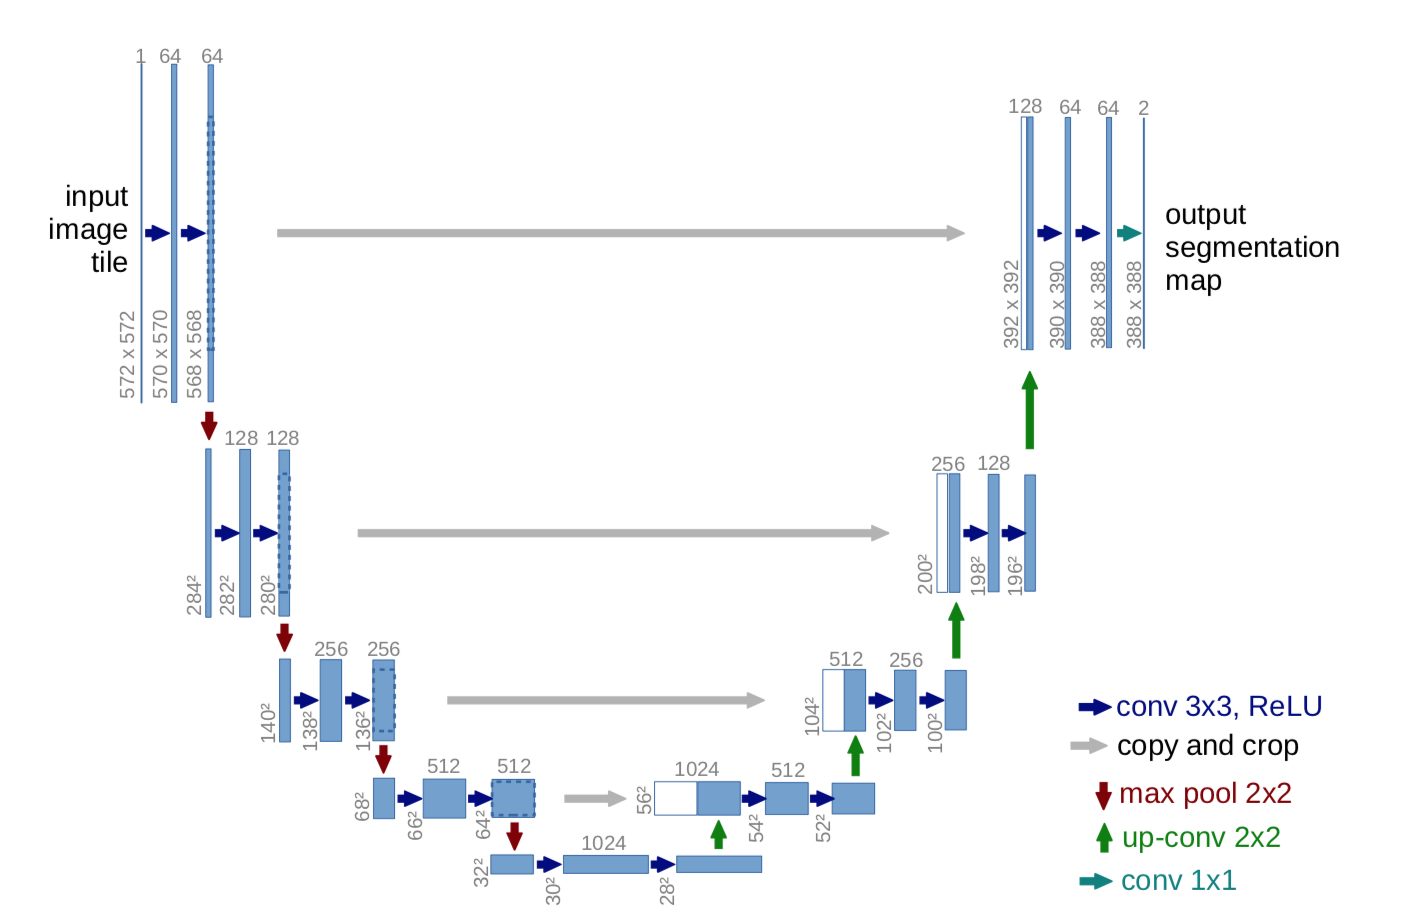

Note: here instead of losing dimensionality by doing valid convolutions (as described in the paper) we pad them therefore eliminating the need for tiling thus using smaller inputs

In [6]:
class UNetEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=0):
        super().__init__()
        
        self.conv_stack = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU()
                ) 

    def forward(self, x):
        out = self.conv_stack(x)
        return out

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=0):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        # concat -> double channels
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=out_channels * 2, out_channels=out_channels, kernel_size=3, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x, skip_conn):
        out = self.upconv(x)
        skip_conn_crop = v2.CenterCrop((out.shape[2], out.shape[3]))(skip_conn)
        out = torch.cat([out, skip_conn_crop], dim=1)
        out = self.conv_stack(out)
        return out
        
    
class UNetEncoder(nn.Module):
    def __init__(self, init_out_channels, padding=0):
        super().__init__()
        self.out_channels = init_out_channels
        self.maxpool = nn.MaxPool2d(2)
        self.conv64 = UNetEncoderBlock(in_channels=3, out_channels=self.out_channels, padding=padding)
        
        
        self.conv128 = UNetEncoderBlock(in_channels=self.out_channels, out_channels=2 * self.out_channels, padding=padding)
        self.out_channels *= 2
        
        
        self.conv256 = UNetEncoderBlock(in_channels=self.out_channels, out_channels=2 * self.out_channels, padding=padding)
        self.out_channels *= 2
                
        self.conv512 = UNetEncoderBlock(in_channels=self.out_channels, out_channels=2 * self.out_channels, padding=padding)
        self.out_channels *= 2
        
        self.conv1024 = UNetEncoderBlock(in_channels=self.out_channels, out_channels=2 * self.out_channels, padding=padding)
        self.out_channels *= 2

    def forward(self, x):
        out64 = self.conv64(x)
        out = self.maxpool(out64)
        
        out128 = self.conv128(out)
        out = self.maxpool(out128)
        
        out256 = self.conv256(out)
        out = self.maxpool(out256)
        
        out512 = self.conv512(out)
        out = self.maxpool(out512)
        
        out = self.conv1024(out)
        return out, [out64, out128, out256, out512]

class UNetDecoder(nn.Module):
    def __init__(self, in_channels, padding=0):
        super().__init__()
        
        self.out_channels = in_channels
        
        self.dec_conv512 = UNetDecoderBlock(in_channels=in_channels, out_channels=self.out_channels // 2, padding=padding)
        self.out_channels //= 2
        
        self.dec_conv256 = UNetDecoderBlock(in_channels=self.out_channels, out_channels=self.out_channels // 2, padding=padding)
        self.out_channels //= 2
        
        self.dec_conv128 = UNetDecoderBlock(in_channels=self.out_channels, out_channels=self.out_channels // 2, padding=padding)
        self.out_channels //= 2
        
        self.dec_conv64 = UNetDecoderBlock(in_channels=self.out_channels, out_channels=self.out_channels // 2, padding=padding)
        self.out_channels //= 2
        
    def forward(self, x, skip_conn: list[...]):
        out = self.dec_conv512(x, skip_conn.pop())
        out = self.dec_conv256(out, skip_conn.pop())
        out = self.dec_conv128(out, skip_conn.pop())
        out = self.dec_conv64(out, skip_conn.pop())
        return out
        
    
class UNet(nn.Module):
    def __init__(self, init_out_channels=64, IMAGE_SIZE=224, num_classes=21, padding=0):
        """num classes: number of actual classes + background (20 + 1 in the VOC 2012 case)"""
        super().__init__()
        
        self.decoder_in_channels = init_out_channels * 2**4
        
        self.encoder = UNetEncoder(init_out_channels=init_out_channels, padding=padding)
        self.dropout = nn.Dropout(p=0.2)
        self.decoder = UNetDecoder(in_channels=self.decoder_in_channels, padding=padding)
#         self.upsample = nn.Upsample((IMAGE_SIZE, IMAGE_SIZE), mode="bilinear")
        self.conv1 = nn.Conv2d(in_channels=init_out_channels, out_channels=num_classes, kernel_size=1)
        
        
        
    def forward(self, x):
        out, skip_conn = self.encoder(x)
        out = self.dropout(out)
        out = self.decoder(out, skip_conn)
#         out = self.upsample(out)
        out = self.conv1(out)
        
        return out
        
        
        
    

# Training

Train loop

In [ ]:
def train_one_epoch(model, train_dl, optimizer, loss_fn, scheduler=None, metrics=True, cat=False):
    size = len(train_dl.dataset)
    num_batches = len(train_dl)
    model.train()
    epoch_loss = 0.
#     batch_loss = 0.
    accuracy = 0.
    iou_score = 0.
    for idx, batch in enumerate(train_dl):
        image, target = batch[0].to(device), batch[1].to(device, dtype=torch.long).squeeze()
        if cat:
            # changing other classes to background
            target = torch.where((target != 8) & (target != 255), 0, target)
            target[target == 8] = 1
            
            
#         image, target = train_tfs(image, target)
        
                    
#         preds = model(pad_tiling(image))
        preds = model(image)
        loss = loss_fn(preds, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None:
            scheduler.step()
            
        epoch_loss += loss.item()
        if metrics:
            tp, fp, fn, tn = smp.metrics.get_stats(preds.argmax(dim=1), target, mode='multilabel', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
#         batch_loss += loss.item()
#         if idx % BATCH_SIZE - 1 == 0:
#             loss, current = batch_loss / BATCH_SIZE, idx * BATCH_SIZE + len(batch[0])
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    iou_score /= num_batches
    accuracy /= num_batches    
    epoch_loss /= num_batches
#     print(f"epoch loss: {epoch_loss / len(train_dl):>10f}")
#     if metrics:
#         print(f"iou score: {iou_score:>2f} \naccuracy: {accuracy:>2f} \n")
    return {"loss" : epoch_loss, "iou" : iou_score.cpu(), "accuracy" : accuracy.cpu()}
    



Test loop

In [ ]:
def test_loop(model, val_dl, loss_fn, metrics=True, cat=False):
    model.eval()
    num_batches = len(val_dl)
    test_loss, correct = 0, 0
    accuracy = 0.
    iou_score = 0.
    with torch.no_grad():
        for batch in val_dl:
            image, target = batch[0].to(device), batch[1].to(device, dtype=torch.long).squeeze()
            if cat:
                # changing other classes to background
                target = torch.where((target != 8) & (target != 255), 0, target)
                target[target == 8] = 1
                 
                
#             preds = model(pad_tiling(image))
            preds = model(image)
            test_loss += loss_fn(preds, target).item()
            if metrics:
                tp, fp, fn, tn = smp.metrics.get_stats(preds.argmax(dim=1), target, mode='multilabel', threshold=0.5)
                iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
                accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    iou_score /= num_batches
    accuracy /= num_batches
#     correct /= size
#     print(f"test loss: {test_loss:>10f}")
#     if metrics:
#         print(f"iou score: {iou_score:>2f} \naccuracy: {accuracy:>2f} \n")
    return {"loss" : test_loss, "iou" : iou_score.cpu(), "accuracy" : accuracy.cpu()}

Metrics

In [ ]:
def print_metrics(metrics_dict):
    print(f"iou score: {metrics_dict['iou']:>2f} \naccuracy: {metrics_dict['accuracy']:>2f} \n")

def plot_metrics(train_metrics: list[dict[str, float]], test_metrics: list[dict[str, float]] = None):
    metric_keys = train_metrics[0].keys()
    
    if test_metrics is not None:
        assert len(train_metrics) == len(test_metrics)
        assert metric_keys == test_metrics[0].keys()
    
    num_plots = len(metric_keys)
    fig, axs = plt.subplots(num_plots, figsize=(8, 8))
    fig.tight_layout()
    
    for idx, key in enumerate(metric_keys):
        train_vals = [d[key] for d in train_metrics]
        axs[idx].set_title(key)
        axs[idx].plot(train_vals, label="train")
        
        if test_metrics is not None:
            test_vals = [d[key] for d in test_metrics]
            axs[idx].plot(test_vals, label="test")
            
        axs[idx].legend()
            
            
        
    

In [ ]:
unet = UNet(init_out_channels=64, num_classes=2 if cat else 21, padding=1).to(device)

In [ ]:
EPOCHS = 160
# unet = UNet(init_out_channels=32, num_classes=2 if cat else 21).to("cuda")
optim = torch.optim.Adam(unet.parameters(), lr=1e-5, weight_decay=1e-8)
# loss_fn = torch.nn.CrossEntropyLoss(weight=cat_weights, ignore_index=255)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
# loss_fn = DiceLoss(mode="multiclass", ignore_index=255)
# loss_fn = FocalLoss(mode="multiclass", alpha=(cat_weights / cat_weights.sum())[1], ignore_index=255)
steps_per_epoch = (len(cat_subset) if cat else len(train_data)) // BATCH_SIZE
scheduler = OneCycleLR(optim, max_lr=3e-5, epochs=EPOCHS, steps_per_epoch=steps_per_epoch)




In [ ]:
train_history = []
test_history = []

In [ ]:
metrics = True
for epoch in range(EPOCHS):
    show_metrics = (epoch + 1) % 5 == 0 
    train_loss = train_one_epoch(model=unet, train_dl=train_dl, optimizer=optim, loss_fn=loss_fn, scheduler=scheduler, metrics=metrics, cat=cat)
    test_loss = test_loop(unet, val_dl, loss_fn=loss_fn, metrics=metrics, cat=cat)
    train_history.append(train_loss)
    test_history.append(test_loss)
    
    print(f"Epoch {epoch + 1}:\n")
    print(f"train loss: {train_loss['loss']:>10f}")
    
    if show_metrics:
        print_metrics(train_loss)
    
    print(f"test loss: {test_loss['loss']:>10f}")
    if show_metrics:
        print_metrics(test_loss)
        
    print("-"*20)
print("Done")

In [ ]:
torch.save(unet.state_dict(), "full_model_ce")

In [ ]:
plot_metrics(train_history, test_history)

# Inference

In [ ]:
show_output_images(unet, val_dl, palette, show_target=True)

## Loading the saved model

In [21]:
def load_palette(filename="palette"):
    with open("palette", "rb") as fp:
        palette = pickle.load(fp)
        return palette

def load_model(filename, cat=False):
    model = UNet(init_out_channels=64, num_classes=2 if cat else 21, padding=1).to(device)
    model.load_state_dict(torch.load(filename))
    model.eval()
    return model


In [8]:
inf_tfs = v2.Compose([
    v2.ToImage(),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    v2.ToDtype(dtype=torch.float32, scale=True),
])

inf_data = wrap_dataset_for_transforms_v2(VOCSegmentation("data", image_set="val", download=True, transforms=inf_tfs)) 

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


In [22]:
if cat:
    cat_indices = get_cat_indices(inf_data, non_cat=0.05)

    cat_subset = torch.utils.data.Subset(inf_data, cat_indices)
    print(len(cat_subset))

93


In [23]:
inf_dl = DataLoader(cat_subset if cat else inf_data, batch_size=8, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

In [26]:
# model = UNet(init_out_channels=64, num_classes=2 if cat else 21, padding=1).to(device)
# model.load_state_dict(torch.load("cat_model_lr_scheduler"))
# model.eval()
# summary(model)
model = load_model("cat_model_dice", cat=True)

In [27]:
palette = load_palette()

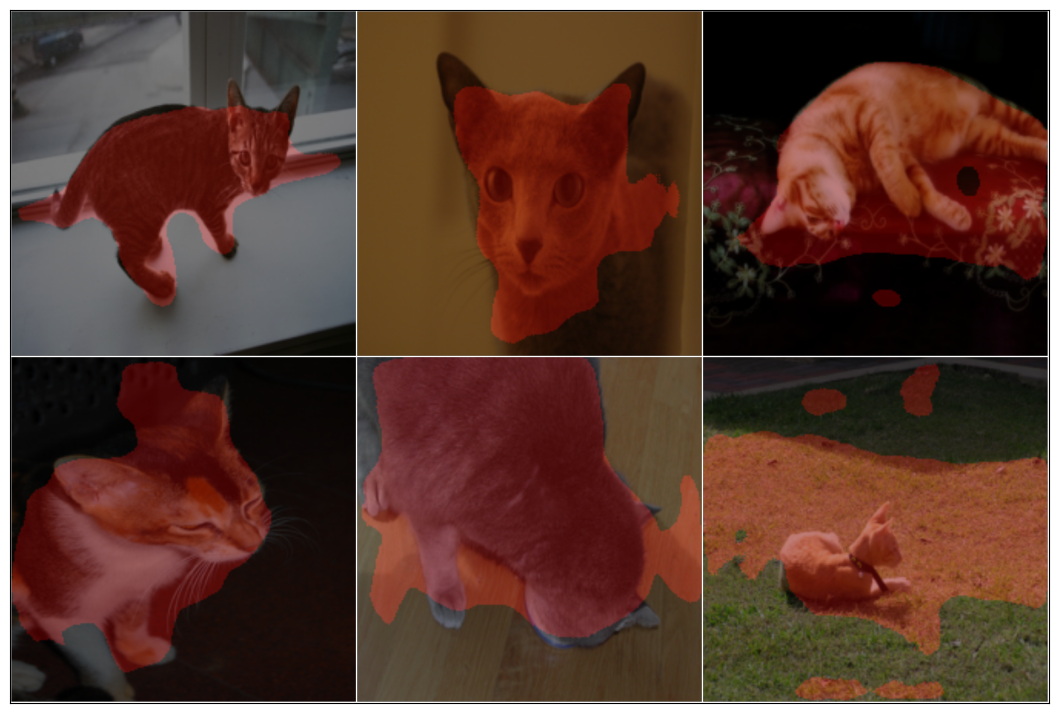

In [29]:
show_output_images(model, inf_dl, palette)

# Building a classifier on top of encoder

In [11]:
class_to_detect = 16 # potted plant

In [14]:
model = load_model("full_model")

In [15]:
encoder = model.encoder
for param in encoder.parameters():
    param.requires_grad = False

In [97]:
class ClassifierOnUNet(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(1024 * 14 * 14, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
            
        )
    
    def forward(self, x):
        x, _ = self.encoder(x)
        x = self.flatten(x)
        x = self.linear_stack(x)
        return x
            


In [98]:
classifier = ClassifierOnUNet(encoder).to(device)
summary(classifier)

Layer (type:depth-idx)                   Param #
ClassifierOnUNet                         --
├─UNetEncoder: 1-1                       --
│    └─MaxPool2d: 2-1                    --
│    └─UNetEncoderBlock: 2-2             --
│    │    └─Sequential: 3-1              (38,976)
│    └─UNetEncoderBlock: 2-3             --
│    │    └─Sequential: 3-2              (221,952)
│    └─UNetEncoderBlock: 2-4             --
│    │    └─Sequential: 3-3              (886,272)
│    └─UNetEncoderBlock: 2-5             --
│    │    └─Sequential: 3-4              (3,542,016)
│    └─UNetEncoderBlock: 2-6             --
│    │    └─Sequential: 3-5              (14,161,920)
├─Flatten: 1-2                           --
├─Sequential: 1-3                        --
│    └─Linear: 2-7                       51,380,480
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       8,224
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      528
│    └─ReLU: 2-12   

In [20]:
train_tfs = v2.Compose([
    v2.ToImage(),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    v2.RandomPhotometricDistort(),
    v2.RandomRotation(180),
    v2.ToDtype(dtype=torch.float32, scale=True),
])
val_tfs = v2.Compose([
    v2.ToImage(),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    v2.ToDtype(dtype=torch.float32, scale=True),
])
train_data = wrap_dataset_for_transforms_v2(VOCSegmentation("data", image_set="train", download=True, transforms=train_tfs)) 
val_data = wrap_dataset_for_transforms_v2(VOCSegmentation("data", image_set="val", download=True, transforms=val_tfs)) 

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


In [21]:
def get_class_indices(data, class_label):
    to_tensor = v2.ToImage()
    class_indices = []
    non_class_indices = []
    for idx, (_, mask) in enumerate(data):
        if class_label in mask:
            class_indices.append(idx)
        elif len(class_indices) > len(non_class_indices):
            non_class_indices.append(idx)
    return class_indices + non_class_indices

In [22]:
train_plant_indices = get_class_indices(train_data, class_to_detect)
val_plant_indices = get_class_indices(val_data, class_to_detect)

train_plant_subset = torch.utils.data.Subset(train_data, train_plant_indices)
val_plant_subset = torch.utils.data.Subset(val_data, val_plant_indices)
print(len(train_plant_subset), len(val_plant_subset))

164 170


In [23]:
BATCH_SIZE = 32
train_dl = DataLoader(train_plant_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
val_dl = DataLoader(val_plant_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

In [24]:
masks = next(iter(train_dl))[1]
masks[masks != class_to_detect] = 0
masks[masks == class_to_detect] = 1
grounds, _ = torch.max(masks.view(masks.shape[0], -1), dim=1)
grounds

tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1], dtype=torch.uint8)

In [99]:
image = next(iter(train_dl))[0]
# encoder(image.to(device))[0].shape
classifier(image.to(device)).shape

torch.Size([32, 2])

In [102]:
def train_one_epoch(model, train_dl, optimizer, loss_fn, metrics=True):
    size = len(train_dl.dataset)
    num_batches = len(train_dl)
    model.train()
    epoch_loss = 0.
#     batch_loss = 0.
    accuracy = 0.
    for idx, batch in enumerate(train_dl):
        image, masks = batch[0].to(device), batch[1].to(device, dtype=torch.long).squeeze()
        
        masks[masks != class_to_detect] = 0
        masks[masks == class_to_detect] = 1
        target, _ = torch.max(masks.view(masks.shape[0], -1), dim=1)
        
        preds = model(image)
        loss = loss_fn(preds, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
        epoch_loss += loss.item()
        if metrics:
            accuracy += (target == preds.argmax(dim=1)).sum() / BATCH_SIZE
#         batch_loss += loss.item()
#         if idx % BATCH_SIZE - 1 == 0:
#             loss, current = batch_loss / BATCH_SIZE, idx * BATCH_SIZE + len(batch[0])
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    accuracy /= num_batches
    epoch_loss /= num_batches
#     print(f"epoch loss: {epoch_loss / len(train_dl):>10f}")
#     if metrics:
#         print(f"iou score: {iou_score:>2f} \naccuracy: {accuracy:>2f} \n")
    return {"loss" : epoch_loss, "accuracy" : accuracy.cpu()}
    



In [103]:
def test_loop(model, val_dl, loss_fn, metrics=True):
    model.eval()
    num_batches = len(val_dl)
    test_loss, correct = 0, 0
    accuracy = 0.
    with torch.no_grad():
        for batch in val_dl:
            image, masks = batch[0].to(device), batch[1].to(device, dtype=torch.long).squeeze()
            
            masks[masks != class_to_detect] = 0
            masks[masks == class_to_detect] = 1
            target, _ = torch.max(masks.view(masks.shape[0], -1), dim=1)
                
#             preds = model(pad_tiling(image))
            preds = model(image)
            test_loss += loss_fn(preds, target).item()
           
            if metrics:
                accuracy += (target == preds.argmax(dim=1)).sum() / BATCH_SIZE

    test_loss /= num_batches
    accuracy /= num_batches
#     correct /= size
#     print(f"test loss: {test_loss:>10f}")
#     if metrics:
#         print(f"iou score: {iou_score:>2f} \naccuracy: {accuracy:>2f} \n")
    return {"loss" : test_loss, "accuracy" : accuracy.cpu()}

In [134]:
EPOCHS = 10
classifier = ClassifierOnUNet(encoder).to(device)
optim = torch.optim.Adam(classifier.parameters(), lr=2e-5, weight_decay=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

In [135]:
train_history = []
test_history = []

In [136]:
metrics = True
for epoch in range(EPOCHS):
#     show_metrics = (epoch + 1) % 5 == 0 
    train_loss = train_one_epoch(model=classifier, train_dl=train_dl, optimizer=optim, loss_fn=loss_fn,metrics=metrics)
    test_loss = test_loop(model=classifier, val_dl=val_dl, loss_fn=loss_fn, metrics=metrics)
    train_history.append(train_loss)
    test_history.append(test_loss)
    
    print(f"Epoch {epoch + 1}:\n")
    print(f"train loss: {train_loss['loss']:>10f}")
    print(f"train acc: {train_loss['accuracy']:>10f}")
    
#     if show_metrics:
#         print_metrics(train_loss)
    
    print(f"test loss: {test_loss['loss']:>10f}")
    print(f"test acc: {test_loss['accuracy']:>10f}")
#     if show_metrics:
#         print_metrics(test_loss)
        
    print("-"*20)
print("Done")

Epoch 1:

train loss:   0.710432
train acc:   0.443750
test loss:   0.691882
test acc:   0.525000
--------------------
Epoch 2:

train loss:   0.684043
train acc:   0.581250
test loss:   0.668730
test acc:   0.650000
--------------------
Epoch 3:

train loss:   0.665174
train acc:   0.612500
test loss:   0.648944
test acc:   0.568750
--------------------
Epoch 4:

train loss:   0.648886
train acc:   0.618750
test loss:   0.629321
test acc:   0.631250
--------------------
Epoch 5:

train loss:   0.634407
train acc:   0.625000
test loss:   0.615442
test acc:   0.662500
--------------------
Epoch 6:

train loss:   0.634195
train acc:   0.631250
test loss:   0.622810
test acc:   0.643750
--------------------
Epoch 7:

train loss:   0.603449
train acc:   0.625000
test loss:   0.610379
test acc:   0.650000
--------------------
Epoch 8:

train loss:   0.610537
train acc:   0.662500
test loss:   0.626120
test acc:   0.618750
--------------------
Epoch 9:

train loss:   0.604227
train acc:   0.

In [137]:
def plot_metrics(train_metrics: list[dict[str, float]], test_metrics: list[dict[str, float]] = None):
    metric_keys = train_metrics[0].keys()
    
    if test_metrics is not None:
        assert len(train_metrics) == len(test_metrics)
        assert metric_keys == test_metrics[0].keys()
    
    num_plots = len(metric_keys)
    fig, axs = plt.subplots(num_plots, figsize=(8, 8))
    fig.tight_layout()
    
    for idx, key in enumerate(metric_keys):
        train_vals = [d[key] for d in train_metrics]
        axs[idx].set_title(key)
        axs[idx].plot(train_vals, label="train")
        
        if test_metrics is not None:
            test_vals = [d[key] for d in test_metrics]
            axs[idx].plot(test_vals, label="test")
            
        axs[idx].legend()

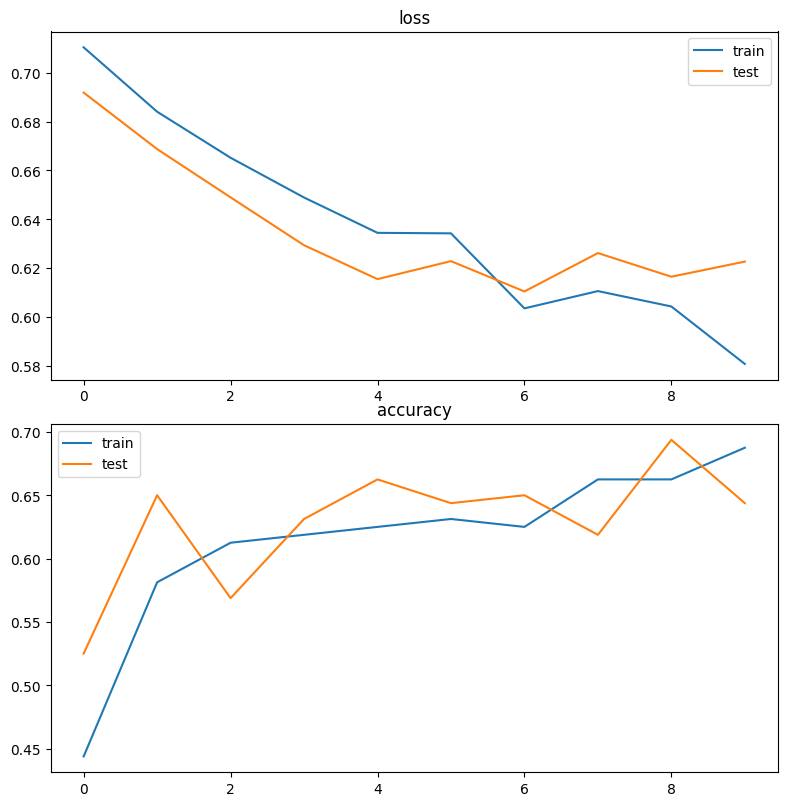

In [138]:
plot_metrics(train_history, test_history)